<a href="https://colab.research.google.com/github/JuanIgnaMurua/Grupo-6-ISPC-Proyecto-HotelExplora/blob/main/Predicci%C3%B3n_Hotel_rating_V2.2.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HotelExplora: Transformando la Experiencia de Reservar con NLP y Deep Learning**

Bienvenidos a la presentación sobre cómo HotelExplora va a transformar la experiencia de reservar con NLP y Deep Learning. Descubriremos cómo estas tecnologías revolucionarias están cambiando la industria hotelera.

In [ ]:
!pip install wordcloud

In [ ]:
# PASO 1: Importar librerías y configuraciones iniciales
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# PASO 2: Cargar los datos
data = pd.read_csv('/content/7282_1.csv', engine='python', on_bad_lines='skip')
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [ ]:
# PASO 3: Preprocesar los datos
#Filtrar calificaciones que son 0
data = data[data['reviews.rating']>0]
#Cambiar el nombre de los nombres de las columnas que tienen un '.' en ellos
data = data.rename(index=str, columns={'reviews.date':'reviewsdate', 'reviews.dateAdded':'reviewsdateAdded',
       'reviews.doRecommend':'reviewsdoRecommend', 'reviews.id':'reviewsid', 'reviews.rating':'reviewsrating', 'reviews.text':'reviewstext',
       'reviews.title':'reviewstitle', 'reviews.userCity':'reviewsuserCity', 'reviews.username':'reviewsusername',
       'reviews.userProvince':'reviewsuserProvince'})
data.reviewstext = data.reviewstext.fillna('x')
#Unas pocas centenas de valoraciones tenían una puntuación superior a 5, filtrando estas
data = data[data['reviewsrating']<=5]
#Unas pocas centenas de valoraciones tenían decimales, redondeando cada una de estas hacia abajo a un entero.
data.reviewsrating = data.reviewsrating.astype(int)


In [ ]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviewsdate,reviewsdateAdded,reviewsdoRecommend,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [ ]:
#PASO 4: Crear una función para limpiar las reseñas
#Crearé una función que usaré para limpiar cadenas de reseñas. La función hará lo siguiente con la cadena 'txt': Convertirá la cadena a minúsculas.Eliminará las palabras vacías (stopwords).Encontrará la longitud de la cadena limpia.Extraerá solo los adjetivos. Devolverá una lista con la longitud de la cadena limpia, la cadena limpia y la cadena que contiene solo adjetivos.
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

In [ ]:
# PASO 5: Mostrar los países únicos en los datos
unique_countries = data['country'].unique()

# Muestra la lista de países únicos
print("Unique countries in the dataset:")
for country in unique_countries:
    print(country)

Unique countries in the dataset:
US


In [ ]:
# PASO 6: Visualizar la ubicación de las reseñas de hoteles
plt1 = go.Scatter(x = data.longitude, y=data.latitude, mode = 'markers')
lyt1 = go.Layout(title="Locations of Hotel Reviews", xaxis=dict(title='Longitude'), yaxis=dict(title='Latitude'))
fig1 = go.Figure(data=[plt1], layout=lyt1)
iplot(fig1)

In [ ]:
# PASO 7: Filtrar datos para incluir solo los puntos dentro de los EE.UU.
data = data[((data['latitude']<=50.0) & (data['latitude']>=24.0)) & ((data['longitude']<=-65.0) & (data['longitude']>=-122.0))]

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# PASO 8: Crear un campo que muestre la longitud de cada reseña
tmp = list()
for i in range(len(data)):
    tmp.append(cleanme(data.iloc[i,:]['reviewstext']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

In [ ]:
# PASO 9: Añadir columnas calculadas de nuevo al conjunto de datos
data = data.reset_index()
data = pd.concat([data,tmp], axis=1)
data

,index,address,categories,city,country,latitude,longitude,name,postalCode,province,...,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince,reviewlen,cleanrev,adjreview
0,60,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,"We had a wonderful, relaxing time. The staff w...",Hospitality at its Best!,Albany,Flo H,NY,36,"wonderful , relaxing time . staff completely a...",wonderful relaxing attentive deluxe available ...
1,61,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,We were in Palm Springs on the day the tempera...,Pure delight!,North Houston,Julie R,TX,37,palm springs day temperature 123 degrees ! des...,palm wonderful little paradise friendly little...
2,62,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,We arrived in Palm Springs not sure what to ex...,Awesome! Quiet secluded tranquility,North Houston,martin n,TX,42,arrived palm springs sure expect .... 's quiet...,sure quiet residential wooden sure spacious we...
3,63,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,This place really is a little paradise!! A bea...,As the title suggests....,Los Angeles,shetravels66,CA,44,place really little paradise ! ! beautiful bou...,little beautiful fresh best comfortable wonder...
4,64,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,...,NaN,5,Spent 3 nights at Little Paradise boutique hot...,Loved this Wonderful Boutique Hotel!,Los Angeles,Mary Ellen R,CA,45,spent 3 nights little paradise boutique hotel ...,little paradise mother-daughter wonderful rela...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29458,35905,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,We truly enjoyed staying at the Elk Springs re...,We Loved It!,Charlotte,randolphtiffany,NC,40,truly enjoyed staying elk springs resort ! qui...,elk quiet peaceful clean perfect helpful last ...
29459,35906,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,We were here for a 2nd time the last weekend o...,Amazing time (both times!!),Charlotte,Sabrina P,NC,36,2nd time last weekend april ( stayed deer hear...,last first first first second more
29460,35907,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,Best of the Best!!!! My family and I stayed in...,Amazing time (both times!!),Charlotte,Chelsa K.,NC,55,best best ! ! ! ! family stayed grin bear cabi...,best best best perfect gorgeous elk profession...
29461,35908,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,...,NaN,5,Amazing Vacation in Beautiful Cabin We stayed ...,Amazing time (both times!!),Charlotte,Heather D.,NC,33,amazing vacation beautiful cabin stayed long w...,beautiful long relaxing most nice most nice bu...


In [ ]:
# PASO 10: Visualizar la frecuencia de la longitud de las reseñas
plt2 = go.Histogram(x = data.reviewlen)
lyt2 = go.Layout(title="Frequency of Review Length", xaxis=dict(title='Review Length', range=[0,400]), yaxis=dict(title='Frequency'))
fig2 = go.Figure(data=[plt2], layout=lyt2)
iplot(fig2)

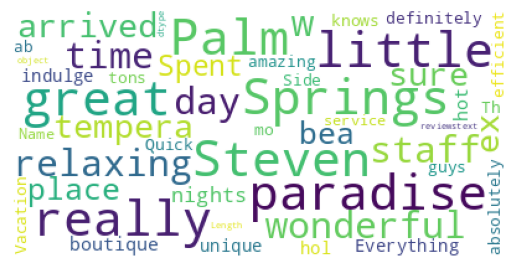

In [ ]:
# PASO 11: Crear y mostrar una nube de palabras
mpl.rcParams['font.size']=12                #10
mpl.rcParams['savefig.dpi']=100             #72
mpl.rcParams['figure.subplot.bottom']=.1
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200,
    max_font_size=40,
    random_state=42
).generate(str(data['reviewstext']))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# PASO 12: Visualizar la longitud de las reseñas frente a la calificación
data = data.sort_values(by='reviewlen')
plt3 = go.Scatter(x = data.reviewlen, y = data.reviewsrating, mode='markers')
lyt3 = go.Layout(title="Review Length vs. Star Rating", xaxis=dict(title='Review Length'),yaxis=dict(title='Rating'))
fig3 = go.Figure(data=[plt3], layout=lyt3)
iplot(fig3)
print("Review Length to Rating Correlation:",data.reviewlen.corr(data.reviewsrating))

Review Length to Rating Correlation: -0.1564923536132389


In [ ]:
# PASO 13: Configurar los datos X e Y para los modelos de machine learning
#Configurar los datos X e Y, donde X es el texto de revisión e Y es la calificación
#Se utilizarán tres entradas diferentes: texto de revisión original, texto de revisión limpio y texto de revisión solo de adjetivos.
x1 = data.reviewstext
x2 = data.cleanrev
x3 = data.adjreview
y = data.reviewsrating

In [ ]:
# PASO 14: Crear un vectorizador para dividir el texto en unigrams y bigrams
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)
x_vect2 = vect.fit_transform(x2)
x_vect3 = vect.fit_transform(x3)

In [ ]:
# PASO 15: Definir funciones para Linear SVC, KNN y Naive Bayes
def entrenar_linsvc(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = LinearSVC(dual=False)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Linear SVC Accuracy:", accuracy)
    return classf, accuracy

def entrenar_knn(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("KNN Accuracy:", accuracy)
    return classf, accuracy

def entrenar_naive_bayes(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Naive Bayes Accuracy:", accuracy)
    return classf, accuracy

In [ ]:
# PASO 16: Entrenar y evaluar los modelos
svm_model, svm_accuracy = entrenar_linsvc(x_vect2, y)
knn_model, knn_accuracy = entrenar_knn(x_vect2, y)
nb_model, nb_accuracy = entrenar_naive_bayes(x_vect2, y)

# Comparamos las precisiones
print("Linear SVC Accuracy:", svm_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)

Linear SVC Accuracy: 0.5065164268259571
KNN Accuracy: 0.14702688026065708
Naive Bayes Accuracy: 0.3995384197664947
Linear SVC Accuracy: 0.5065164268259571
KNN Accuracy: 0.14702688026065708
Naive Bayes Accuracy: 0.3995384197664947


In [ ]:
# Crear y mostrar una matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
  Esta función imprime y traza la matriz de confusión.
 La normalización se puede aplicar configurando `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1530   51   60   46   66]
 [ 114 1442  194   96   72]
 [  59   65 2810  303  242]
 [  29   24  189 4633  744]
 [  21   15   84  411 6994]]
Confusion matrix, without normalization
[[1743    5    3    2    0]
 [1802  107    5    4    0]
 [3203   21  240    9    6]
 [5147   19   76  350   27]
 [6809   34  100  181  401]]
Confusion matrix, without normalization
[[  96    0   38  340 1279]
 [   0   14   63  544 1297]
 [   2    0  537  594 2346]
 [   1    0   13 2647 2958]
 [   0    0    7   56 7462]]


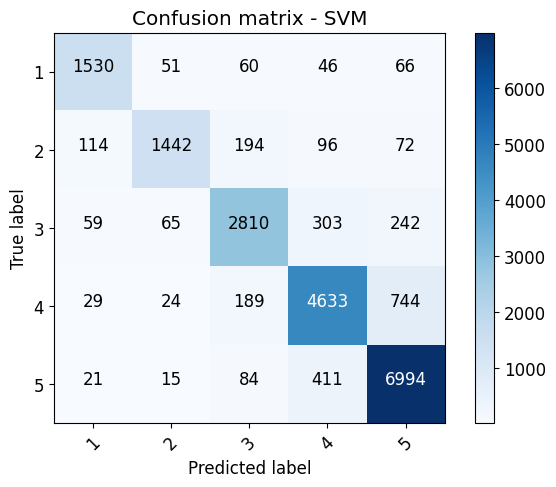

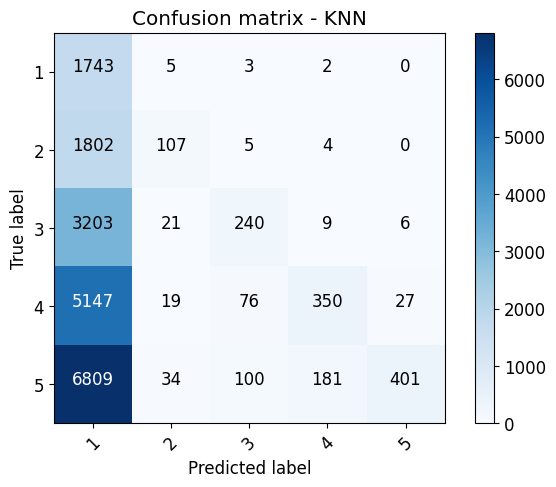

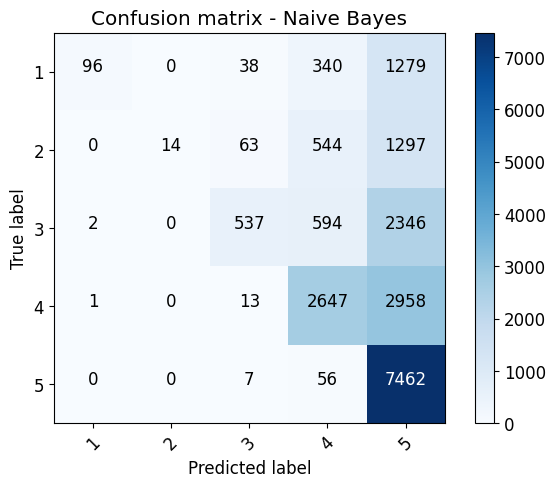

In [ ]:
# Generar y graficar las matrices de confusión
c1 = confusion_matrix(y, svm_model.predict(x_vect2))
c2 = confusion_matrix(y, knn_model.predict(x_vect2))
c3 = confusion_matrix(y, nb_model.predict(x_vect2))
class_names = ['1', '2', '3', '4', '5']
plt.figure()
plot_confusion_matrix(c1, classes=class_names, normalize=False, title='Confusion matrix - SVM')
plt.figure()
plot_confusion_matrix(c2, classes=class_names, normalize=False, title='Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c3, classes=class_names, normalize=False, title='Confusion matrix - Naive Bayes')
plt.show()


In [ ]:
print(data.columns)

Index(['index', 'address', 'categories', 'city', 'country', 'latitude',
       'longitude', 'name', 'postalCode', 'province', 'reviewsdate',
       'reviewsdateAdded', 'reviewsdoRecommend', 'reviewsid', 'reviewsrating',
       'reviewstext', 'reviewstitle', 'reviewsuserCity', 'reviewsusername',
       'reviewsuserProvince', 'reviewlen', 'cleanrev', 'adjreview'],
      dtype='object')


In [ ]:
city_list = data['city'].tolist()

In [ ]:
print(city_list)

['Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Glendale', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermo

##**Sistema de recomendación y de clasificación de hoteles por rating y ciudad utilizando NLP**##

Este código define una función hotel_recommendation_by_city_rating que recomienda hoteles en una ciudad dada con una clasificación dentro de un rango específico. Filtra los datos según la ciudad y el rango de clasificación, luego calcula el promedio de clasificación para cada hotel y devuelve las tres mejores recomendaciones.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# Función para limpiar las reseñas
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

# Función para recomendación de hoteles por rating y ciudad
def try_convert_to_numeric(value):
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

def hotel_recommendation_by_city_rating(city, rating, data):
    # Filtrar los datos para la ciudad específica
    city_data = data[data['city'] == city]

    # Filtrar por rating dentro de un rango más amplio
    similar_hotels = city_data[(city_data['reviewsrating'] >= rating - 1) & (city_data['reviewsrating'] <= rating + 1)]

    # Convertir la columna 'reviewsrating' a tipo numérico
    similar_hotels['reviewsrating'] = similar_hotels['reviewsrating'].apply(try_convert_to_numeric)

    # Eliminar filas con valores no numéricos en la columna 'reviewsrating'
    similar_hotels = similar_hotels.dropna(subset=['reviewsrating'])

    # Agrupar por nombre y dirección del hotel y calcular el promedio del rating
    similar_hotels_grouped = similar_hotels.groupby(['name', 'address'])['reviewsrating'].mean().reset_index()

    # Ordenar por rating en orden descendente
    top_recommendations = similar_hotels_grouped.sort_values(by='reviewsrating', ascending=False).head(3)

    return top_recommendations


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Ejemplo de uso 1:
city ='Houston'
rating = 5
recommendations = hotel_recommendation_by_city_rating(city, rating, data)
print(recommendations)

                                        name            address  reviewsrating
1  Embassy Suites By Hilton Houston Downtown     1515 Dallas St       5.000000
2                      La Quinta Inn-houston    930 Normandy St       5.000000
4                       The Houstonian Hotel  111 N Post Oak Ln       4.830508


<ipython-input-32-5f76f2e09cfd>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Ejemplo de uso 2:
city ='Palm Springs'
rating = 5
recommendations = hotel_recommendation_by_city_rating(city, rating, data)
print(recommendations)

                    name                address  reviewsrating
0  Little Paradise Hotel  435 E Avenida Olancha           4.85


# **Sistema de recomendación de hoteles por ciudad y rating usando SVM y TF-ID**

El objetivo del sistema es recomendar hoteles en una ciudad específica con una calificación determinada, utilizando un modelo de máquina de soporte vectorial (SVM) previamente entrenado y un vectorizador TF-IDF. La recomendación se basa en las reseñas de los usuarios.




In [ ]:
def recommend_hotels(city, rating_range, model, vectorizer, data):
    # Filtrar los datos por ciudad
    filtered_data = data[data['city'].str.lower() == city.lower()]

    if filtered_data.empty:
        print("No se encontraron hoteles en la ciudad especificada.")
        return

    # Calcular el promedio de calificaciones para cada hotel
    avg_ratings = filtered_data.groupby('name')['reviewsrating'].mean()

    # Definir los rangos de calificación
    rating_ranges = {
        1: (0.5, 1.4),
        2: (1.5, 2.4),
        3: (2.5, 3.4),
        4: (3.5, 4.4),
        5: (4.5, 5)
    }

    # Filtrar los hoteles por el rango de calificación deseado
    min_rating, max_rating = rating_ranges[rating_range]
    filtered_hotels = avg_ratings[(avg_ratings >= min_rating) & (avg_ratings <= max_rating)]

    if filtered_hotels.empty:
        print("No se encontraron hoteles con el rating deseado en la ciudad especificada.")
        return

    # Mostrar los hoteles recomendados
    print("Hoteles recomendados en {} con una calificación de {} a {}: \n".format(city, min_rating, max_rating))
    for hotel_name, avg_rating in filtered_hotels.items():
        # Filtrar datos del hotel
        hotel_data = filtered_data[filtered_data['name'] == hotel_name].iloc[0]
        print("Nombre del hotel: ", hotel_name)
        print("Promedio de calificación: ", avg_rating)
        print("Dirección: ", hotel_data['address'])
        print("Comentario de muestra: ", hotel_data['reviewstext'])
        print("\n")

In [ ]:
recommend_hotels("Columbia", 4, svm_model, vect, data)

Hoteles recomendados en Columbia con una calificación de 3.5 a 4.4: 

Nombre del hotel:  Springhill Suites Columbia
Promedio de calificación:  4.061728395061729
Dirección:  7055 Minstrel Way
Comentario de muestra:  We love to stay at a Marriott whenever we can. I had business in the area and needed a nice clean, safe location close to the main highway. This place did not disappoint! Easy to access, very friendly staff, clean rooms and even cleaner bathroom! Loved the toilet and shower were separate with a sink in both rooms. Mini fridge... More


Nombre del hotel:  Super 8 Columbia East
Promedio de calificación:  3.75
Dirección:  5700 Freedom Dr
Comentario de muestra:  Nothing fancy, but this was a motel that felt safe, clean and had friendly, helpful staff. I would certainly stay here again. Excellent price for what we got.




#**"Modelo de clasificación de imágenes de hoteles mediante transferencia de aprendizaje con ResNet50 y Deep Learning**#


Objetivo: Desarrollar un modelo de clasificación de imágenes de hoteles utilizando transferencia de aprendizaje con ResNet50, optimizado para precisión y eficiencia. Este modelo empleará técnicas avanzadas de Deep Learning para diferenciar categorías de habitaciones de hotel, mejorando así la automatización en la clasificación visual de alojamientos y facilitando la gestión de imágenes en aplicaciones turísticas y hoteleras.

Mounted at /content/drive
Found 897 images belonging to 5 classes.
Found 221 images belonging to 5 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/3
29/29 [==============================] - 291s 10s/step - loss: 1.1818 - accuracy: 0.6332 - val_loss: 0.5717 - val_accuracy: 0.7828
Epoch 2/3
29/29 [==============================] - 231s 8s/step - loss: 0.4726 - accuracy: 0.8205 - val_loss: 0.7884 - val_accuracy: 0.7421
Epoch 3/3
7/7 [==============================] - 51s 7s/step - loss: 0.5378 - accuracy: 0.8009
Precisión del modelo: 80.09%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



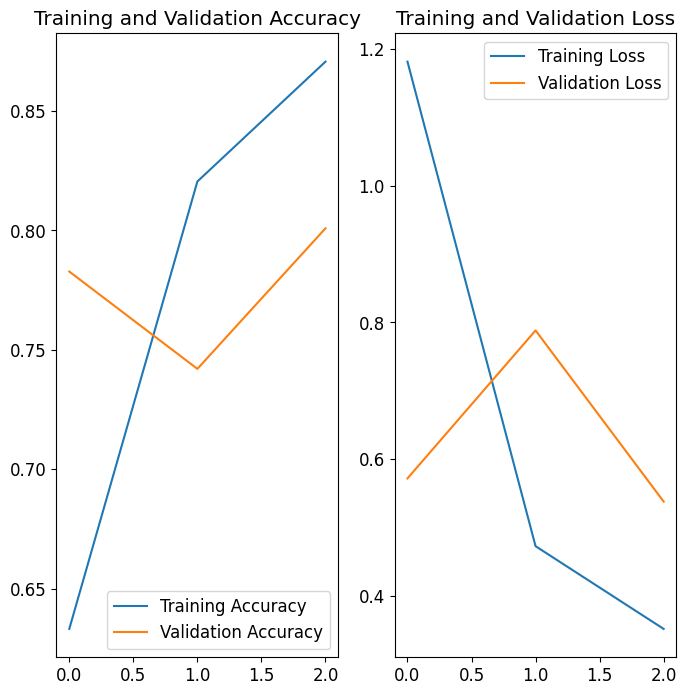

1/1 [==============================] - 1s 1s/step


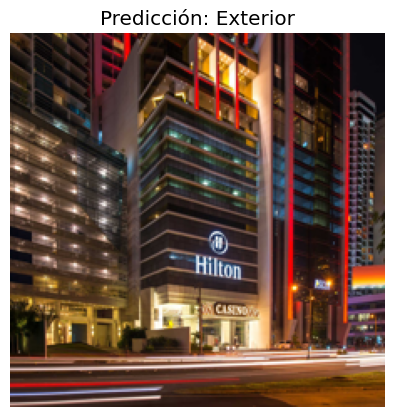

In [ ]:
#importa las bibliotecas necesarias. Se utilizan TensorFlow y Keras para construir y entrenar el modelo,
#así como otras bibliotecas auxiliares para la manipulación de imágenes y gráficos.
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from PIL import Image
from io import BytesIO
from google.colab import drive

def train_and_evaluate_model():
    #Monta Google Drive para acceder a los datos y guardar el modelo entrenado.
    drive.mount('/content/drive')

    # Paso 2: Cargar y preprocesar los datos
    #Esta función entrena un modelo de clasificación de imágenes usando ResNet50 y evalúa su rendimiento.
    data_dir = '/content/drive/My Drive/dataset'
    img_height, img_width = 224, 224
    batch_size = 32

    # Generador de datos para entrenamiento y validación
    # el 20% de los datos se utilizan para la validación (test) y el 80% restante se utiliza para el entrenamiento.
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    # Paso 3: Construir y entrenar el modelo con ResNet50
    #Crea el modelo base usando ResNet50 preentrenado (sin la capa superior). Luego, construye un modelo secuencial que añade una capa de pooling global,
    # una capa densa de 512 neuronas y una capa de salida con una activación softmax para la clasificación.
    #Compila el modelo con el optimizador Adam y la pérdida de entropía cruzada categórica. Luego, se entrena el modelo por 3 épocas y se guarda el historial de entrenamiento.
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Congelar las capas base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 3
    steps_per_epoch = (train_generator.samples + batch_size - 1) // batch_size
    validation_steps = (validation_generator.samples + batch_size - 1) // batch_size

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps
    )

    # Paso 4: Evaluar el modelo
    #Evalúa el modelo en el conjunto de validación y muestra la precisión obtenida.
    loss, accuracy = model.evaluate(validation_generator)
    print(f'Precisión del modelo: {accuracy * 100:.2f}%')

    # Guardar el modelo
    #Guarda el modelo entrenado en Google Drive.
    model.save('/content/drive/My Drive/hotel_room_classifier_resnet50.h5')

    # Graficar los resultados de entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Devolver el modelo y las etiquetas de clase
    #Genera gráficos de precisión y pérdida para los conjuntos de entrenamiento y validación
    #Devuelve el modelo entrenado y los índices de clase.
    return model, train_generator.class_indices

def load_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalizar la imagen usando preprocess_input de ResNet50
    return img, img_array

def predict_image_from_url(url, model, class_indices):
    # Cargar y preprocesar la imagen desde la URL
    img, img_array = load_image_from_url(url, target_size=(224, 224))

    # Realizar la predicción
    prediction = model.predict(img_array)

    # Mostrar la imagen y la predicción
    plt.imshow(img)
    plt.axis('off')
    predicted_class = np.argmax(prediction[0])
    class_labels = {v: k for k, v in class_indices.items()}  # Reemplaza índices con etiquetas
    predicted_label = class_labels[predicted_class]
    plt.title(f'Predicción: {predicted_label}')
    plt.show()

# Ejecutar la función para entrenar y evaluar el modelo
model, class_indices = train_and_evaluate_model()

# URL de la imagen que deseas predecir
image_url = 'https://nextcomsystems.com/wp-content/uploads/2017/04/PTYHFHF_quicklook_full_exterior01.jpg'
predict_image_from_url(image_url, model, class_indices)
